In [1]:
import os, re, random, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_recall_fscore_support,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

DATA_PATH = "consumer_complaints.csv"  


DEVICE: cpu


In [2]:
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print("Columns:", list(df.columns))

# Hedef kolon adayları
TARGET_CANDS = ["consumer_disputed?", "consumer_disputed", "disputed", "target", "label"]
target_col = next((c for c in TARGET_CANDS if c in df.columns), None)
if target_col is None:
    raise ValueError(f"Hedef kolon bulunamadı. Adaylar: {TARGET_CANDS}")

# Binary label: Yes/No -> 1/0 (farklı stringler varsa genişlet)
def to01(x):
    if isinstance(x, str):
        x2 = x.strip().lower()
        if x2 in ["yes", "y", "1", "true"]:
            return 1
        if x2 in ["no", "n", "0", "false"]:
            return 0
    if pd.isna(x):
        return np.nan
    return int(x)

y = df[target_col].apply(to01)
df = df.loc[~y.isna()].copy()
df["label"] = y.loc[~y.isna()].astype(int)

print("Label dağılım (adet):")
print(df["label"].value_counts())
print("Label dağılım (oran):")
print(df["label"].value_counts(normalize=True))


/var/folders/5r/1nlqqb5n7h7ffc06kqd_9t580000gn/T/ipykernel_6058/4144799808.py:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


Shape: (555957, 18)
Columns: ['date_received', 'product', 'sub_product', 'issue', 'sub_issue', 'consumer_complaint_narrative', 'company_public_response', 'company', 'state', 'zipcode', 'tags', 'consumer_consent_provided', 'submitted_via', 'date_sent_to_company', 'company_response_to_consumer', 'timely_response', 'consumer_disputed?', 'complaint_id']
Label dağılım (adet):
label
0    443823
1    112134
Name: count, dtype: int64
Label dağılım (oran):
label
0    0.798305
1    0.201695
Name: proportion, dtype: float64


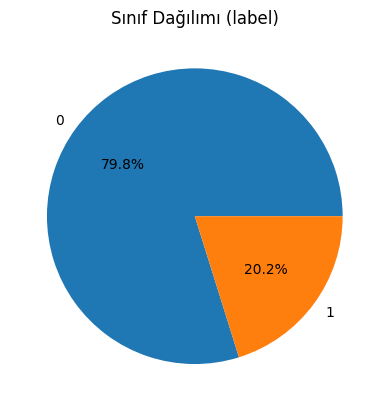

count    555957.000000
mean         22.908541
std          84.776148
min           0.000000
50%           0.000000
90%          53.000000
95%         166.000000
99%         475.000000
max        1284.000000
Name: text_len_words, dtype: float64


In [4]:
TEXT_COL_CANDS = ["consumer_complaint_narrative", "consumer complaint narrative", "complaint_what_happened"]
text_col = next((c for c in TEXT_COL_CANDS if c in df.columns), None)
if text_col is None:
    raise ValueError(f"Metin kolonu bulunamadı. Adaylar: {TEXT_COL_CANDS}")

df[text_col] = df[text_col].fillna("").astype(str)

# Sınıf dağılım grafiği 
counts = df["label"].value_counts()
plt.figure()
plt.title("Sınıf Dağılımı (label)")
plt.pie(counts.values, labels=[str(i) for i in counts.index], autopct="%1.1f%%")
plt.show()

# Metin uzunluğu kontrol (EDA)
df["text_len_words"] = df[text_col].str.split().str.len()
print(df["text_len_words"].describe(percentiles=[0.5, 0.9, 0.95, 0.99]))


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df[text_col].values, df["label"].values,
    test_size=0.2, random_state=SEED, stratify=df["label"].values
)

def show_split_dist(y, name):
    vc = pd.Series(y).value_counts()
    print(f"\n{name} dağılım:")
    print(vc)
    print("oran:", (vc / vc.sum()).to_dict())

show_split_dist(y_train, "TRAIN")
show_split_dist(y_test, "TEST")



TRAIN dağılım:
0    355058
1     89707
Name: count, dtype: int64
oran: {0: 0.7983047227187391, 1: 0.20169527728126088}

TEST dağılım:
0    88765
1    22427
Name: count, dtype: int64
oran: {0: 0.7983038348082596, 1: 0.2016961651917404}


In [6]:
def basic_tokenize(s: str):
    s = s.lower()
    s = re.sub(r"[^a-z0-9\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s.split()

# Vocab
from collections import Counter

MAX_VOCAB = 30000
MIN_FREQ = 2
PAD, UNK = "<pad>", "<unk>"

ctr = Counter()
for t in X_train:
    ctr.update(basic_tokenize(t))

vocab = [PAD, UNK] + [w for w, f in ctr.items() if f >= MIN_FREQ]
vocab = vocab[:MAX_VOCAB]
stoi = {w:i for i,w in enumerate(vocab)}
itos = {i:w for w,i in stoi.items()}

print("Vocab size:", len(stoi))

MAX_LEN = 200  
def encode(text):
    toks = basic_tokenize(text)
    ids = [stoi.get(tok, stoi[UNK]) for tok in toks[:MAX_LEN]]
    if len(ids) < MAX_LEN:
        ids += [stoi[PAD]] * (MAX_LEN - len(ids))
    return np.array(ids, dtype=np.int64)

X_train_ids = np.stack([encode(t) for t in X_train])
X_test_ids  = np.stack([encode(t) for t in X_test])

print("Train ids:", X_train_ids.shape, "Test ids:", X_test_ids.shape)


Vocab size: 24412
Train ids: (444765, 200) Test ids: (111192, 200)


In [7]:
class TextDataset(Dataset):
    def __init__(self, X_ids, y):
        self.X = torch.from_numpy(X_ids)
        self.y = torch.from_numpy(y.astype(np.int64))
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 128

train_ds = TextDataset(X_train_ids, y_train)
test_ds  = TextDataset(X_test_ids,  y_test)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


In [8]:
def compute_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    auc = roc_auc_score(y_true, y_prob)

    return {"accuracy": acc, "balanced_acc": bacc, "precision": prec, "recall": rec, "f1": f1, "auc": auc}

def plot_roc_curve(y_true, y_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title(title)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()

@torch.no_grad()
def predict_proba(model, dl):
    model.eval()
    probs = []
    ys = []
    for xb, yb in dl:
        xb = xb.to(DEVICE)
        logits = model(xb)
        p = torch.sigmoid(logits).detach().cpu().numpy().reshape(-1)
        probs.append(p)
        ys.append(yb.numpy().reshape(-1))
    return np.concatenate(ys), np.concatenate(probs)

def train_one_epoch(model, dl, opt, loss_fn):
    model.train()
    total = 0.0
    n = 0
    for xb, yb in dl:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE).float()

        opt.zero_grad()
        logits = model(xb).reshape(-1)
        loss = loss_fn(logits, yb)
        loss.backward()
        opt.step()

        total += loss.item() * len(yb)
        n += len(yb)
    return total / max(n,1)


In [9]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, num_filters=128, kernel_sizes=(3,4,5), dropout=0.3):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=emb_dim, out_channels=num_filters, kernel_size=k)
            for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), 1)

    def forward(self, x):  # (B, L)
        e = self.emb(x)          # (B, L, E)
        e = e.transpose(1,2)     # (B, E, L)
        feats = []
        for conv in self.convs:
            c = torch.relu(conv(e))             # (B, F, L-k+1)
            p = torch.max(c, dim=2).values      # (B, F)
            feats.append(p)
        h = torch.cat(feats, dim=1)             # (B, F*len(K))
        h = self.dropout(h)
        out = self.fc(h)                        # (B, 1)
        return out


In [ ]:
def run_train_eval_textcnn(lr=2e-3, dropout=0.3, epochs=5):
    model = TextCNN(vocab_size=len(stoi), dropout=dropout).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()

    best_f1 = -1
    best_state = None

    for ep in range(1, epochs+1):
        tr_loss = train_one_epoch(model, train_dl, opt, loss_fn)
        yt, pt = predict_proba(model, test_dl)
        metrics = compute_metrics(yt, pt)
        print(f"[TextCNN] ep={ep} loss={tr_loss:.4f} metrics={metrics}")

        if metrics["f1"] > best_f1:
            best_f1 = metrics["f1"]
            best_state = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}

    model.load_state_dict(best_state)
    yt, pt = predict_proba(model, test_dl)
    return model, yt, pt, compute_metrics(yt, pt)

grid = [
    {"lr": 2e-3, "dropout": 0.3},
    {"lr": 1e-3, "dropout": 0.5},
]

best = None
for g in grid:
    print("\nGrid:", g)
    m, yt, pt, met = run_train_eval_textcnn(lr=g["lr"], dropout=g["dropout"], epochs=5)
    if best is None or met["f1"] > best["metrics"]["f1"]:
        best = {"name": "TextCNN", "grid": g, "model": m, "y_true": yt, "y_prob": pt, "metrics": met}

best_textcnn = best
best_textcnn["metrics"], best_textcnn["grid"]

def train_one_epoch(model, dl, opt, loss_fn):
    model.train()
    total = 0.0
    n = 0
    t0 = time.time()
    for i, (xb, yb) in enumerate(dl, start=1):
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE).float()

        opt.zero_grad()
        logits = model(xb).reshape(-1)
        loss = loss_fn(logits, yb)
        loss.backward()
        opt.step()

        total += loss.item() * len(yb)
        n += len(yb)

        if i % 50 == 0:
            print(f"step {i}/{len(dl)}  loss={loss.item():.4f}  elapsed={time.time()-t0:.1f}s")
    return total / max(n,1)

